# Team Identification Use Case for NBA Detection
Given an image with bounding boxes generated by our code, this is a pipeline to train and predict the team that a player belongs to.

## Initialization
Clone the git repository and set up the code

In [1]:
!pip install roboflow
!pip install pycocotools

Initialized empty Git repository in /content/.git/
remote: Enumerating objects: 637, done.
remote: Counting objects: 100% (102/102), done.
remote: Compressing objects: 100% (61/61), done.
remote: Total 637 (delta 47), reused 64 (delta 28), pack-reused 535
Receiving objects: 100% (637/637), 8.32 MiB | 21.51 MiB/s, done.
Resolving deltas: 100% (347/347), done.
From https://github.com/fjzs/NBA-Detector
 * branch            main       -> FETCH_HEAD
 * [new branch]      main       -> origin/main
From https://github.com/fjzs/NBA-Detector
 * branch            main       -> FETCH_HEAD
Branch 'main' set up to track remote branch 'main' from 'origin'.
Switched to a new branch 'main'
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 kB 3.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 4.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.8/67.8 kB 

/content/src/nba_detector


## Imports

In [2]:
import os
from sklearn.model_selection import train_test_split
from player_classification import knn_classification, get_player_team_dataset, knn_preprocess
from dataset import download_dataset_from_roboflow
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset 
from sklearn.preprocessing import LabelEncoder

## Constants

In [3]:
version_id = 11
dataset_path: str = 'NBA-Player-Detector-{}'.format(version_id)

## Set up dataset

In [4]:
if dataset_path not in os.listdir():
    download_dataset_from_roboflow(format='coco', version_id=version_id)
train_images, train_labels = get_player_team_dataset(os.path.join(dataset_path, 'train'))
val_images, val_labels = get_player_team_dataset(os.path.join(dataset_path, 'valid'))
print('{} images in train set'.format(len(train_images)))
print('{} images in testing set'.format(len(val_images)))

loading Roboflow workspace...
loading Roboflow project...


Extracting Dataset Version Zip to NBA-Player-Detector-11 in coco:: 100%|██████████| 373/373 [00:00<00:00, 761.67it/s]


loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
1295 images in train set
302 images in testing set


## Train a Simple KNN model

In [5]:
print('Training on {} unique teams\nTeam names: {}'.format(len(set(train_labels)), list(set(train_labels))))
knn_model = knn_classification(train_images, train_labels, len(set(train_labels)))
test_images, test_labels = knn_preprocess(val_images, val_labels)
team_predictions = knn_model.predict(test_images)
knn_accuracy = sum(test_labels == team_predictions) / len(test_labels)
print('Accuracy: {}\nCorrectly classified {} out of {}'.\
      format(knn_accuracy, sum([test_labels[i] == team_predictions[i] for i 
                                in range(len(test_labels))]), len(test_labels)))

Training on 6 unique teams
Team names: ['MTW', 'SAS', 'MEM', 'GSW', 'PHX', 'DEN']
Accuracy: 0.6291390728476821
Correctly classified 190 out of 302


## Creating a Neural Network to classify teams

### Dataloader
This extracts images given the original image and bounding boxes in COCO format

In [6]:
class TeamDataset(Dataset):
    def __init__(self, images: list, labels: list, transform: transforms) -> None:
        super(TeamDataset, self).__init__()
        self.images = images
        self.labels = labels
        self.transform = transform
        label_encoder = LabelEncoder()
        self.labels = label_encoder.fit_transform(self.labels)

    
    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self, index):
        image = self.images[index]
        label = self.labels[index]

        image = torch.tensor(image)
        image = image.permute((2, 0, 1))
        image = self.transform(image)
        return image, label

### Loading the data

In [7]:
train_images, train_labels = get_player_team_dataset(os.path.join(dataset_path, 'train'))
val_images, val_labels = get_player_team_dataset(os.path.join(dataset_path, 'valid'))

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Using {}'.format(device))
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])
teamClassicationDataset = TeamDataset(train_images, train_labels, transform)
trainloader = DataLoader(teamClassicationDataset, batch_size=32, shuffle=True)

valTeamClassicationDataset = TeamDataset(val_images, val_labels, transform)
valloader = DataLoader(valTeamClassicationDataset, batch_size=32, shuffle=False)
print('Train and validation datasets have been loaded and will be used as training and testing datasets.')

loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
Using cuda
Train and validation datasets have been loaded and will be used as training and testing datasets.


### Model
Designing a simple MLP

In [8]:
class MLP(nn.Module):
    def __init__(self, num_classes: int, input_size: int, hidden_size: int) -> None:
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU(inplace=True)
        self.fc2 = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        out = x.view(x.size(0), -1) 
        out = self.relu(self.fc1(out))
        out = self.fc2(out)
        return out

mlp = MLP(num_classes=len(set(train_labels)), input_size=150528, hidden_size=1000).to(device)
mlp_criterion = nn.CrossEntropyLoss()
mlp_optimizer = optim.SGD(mlp.parameters(), lr=0.001, momentum=0.9)

Designing a simple CNN

In [9]:
class CNN(nn.Module):
    def __init__(self, num_classes: int, in_channels: int = 3) -> None:
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, 32, 3, stride=2, padding=1)
        self.relu1 = nn.ReLU(inplace=True)
        self.pool1 = nn.MaxPool2d(2, 2)
        self.dropout1 = nn.Dropout(0.2)

        self.conv2 = nn.Conv2d(32, 64, 3, stride=2, padding=1)
        self.relu2 = nn.ReLU(inplace=True)
        self.pool2 = nn.MaxPool2d(2, 2)
        self.dropout2 = nn.Dropout(0.2)

        self.fc1 = nn.Linear(14*14*64, 5000)
        self.relu4 = nn.ReLU(inplace=True)
        self.fc2 = nn.Linear(5000, 500)
        self.relu5 = nn.ReLU(inplace=True)
        self.fc3 = nn.Linear(500, num_classes)

    def forward(self, x):
        out = self.pool1(self.relu1(self.conv1(x)))
        out = self.dropout1(out)
        out = self.pool2(self.relu2(self.conv2(out)))
        out = self.dropout2(out)

        out = out.view(out.size(0), -1)
        
        out = self.relu4(self.fc1(out))
        out = self.relu5(self.fc2(out))
        out = self.fc3(out)
        return out

cnn = CNN(num_classes=len(set(train_labels))).to(device)
cnn_criterion = nn.CrossEntropyLoss()
cnn_optimizer = optim.Adam(cnn.parameters(), lr=0.001)

### Training

In [10]:
def train(model, optimizer, criterion, trainloader, epochs: int = 5):
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0

        for inputs, labels in tqdm(trainloader):
            inputs = inputs.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        model.eval()
        val_loss = 0.0
        correct = 0
        total = 0

        with torch.no_grad():
            for inputs, labels in trainloader:
                inputs = inputs.to(device)
                labels = labels.to(device)

                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        accuracy = correct / total
        print('Epoch {}, Train Loss: {:.4f} Train Accuracy: {:.2f}'.format(epoch, running_loss, accuracy))

epochs = 20
print('\nTraining MLP')
train(mlp, mlp_optimizer, mlp_criterion, trainloader, epochs)
print('\nTraining CNN')
train(cnn, cnn_optimizer, cnn_criterion, trainloader, epochs)


Training MLP


To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch 0, Train Loss: 57.0917 Train Accuracy: 0.45
Epoch 1, Train Loss: 44.9912 Train Accuracy: 0.58
Epoch 2, Train Loss: 39.5029 Train Accuracy: 0.63
Epoch 3, Train Loss: 35.6147 Train Accuracy: 0.70
Epoch 4, Train Loss: 31.7042 Train Accuracy: 0.73
Epoch 5, Train Loss: 28.0194 Train Accuracy: 0.79
Epoch 6, Train Loss: 25.7974 Train Accuracy: 0.75
Epoch 7, Train Loss: 25.7182 Train Accuracy: 0.80
Epoch 8, Train Loss: 23.0560 Train Accuracy: 0.80
Epoch 9, Train Loss: 23.5912 Train Accuracy: 0.82
Epoch 10, Train Loss: 23.9932 Train Accuracy: 0.81
Epoch 11, Train Loss: 24.7234 Train Accuracy: 0.84
Epoch 12, Train Loss: 19.8867 Train Accuracy: 0.90
Epoch 13, Train Loss: 16.7468 Train Accuracy: 0.89
Epoch 14, Train Loss: 15.7765 Train Accuracy: 0.82
Epoch 15, Train Loss: 16.7573 Train Accuracy: 0.87
Epoch 16, Train Loss: 16.7815 Train Accuracy: 0.77
Epoch 17, Train Loss: 14.2383 Train Accuracy: 0.93
Epoch 18, Train Loss: 12.5131 Train Accuracy: 0.92
Epoch 19, Train Loss: 13.2753 Train Accur

### Check accuracy

In [11]:
def check_accuracy(valloader, model):
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    predictions: list[str] = []
    with torch.no_grad():
        for inputs, labels in valloader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            predictions.extend(predicted.cpu().numpy())
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = correct / total
    return accuracy, correct, total, predictions

mlp_accuracy, mlp_correct, total, mlp_predictions = check_accuracy(valloader, mlp)
print('\nMLP model:\nAccuracy: {}\nCorrectly identified {} out of {}'.format(mlp_accuracy, mlp_correct, total))
cnn_accuracy, cnn_correct, total, cnn_predictions = check_accuracy(valloader, cnn)
print('\nCNN model:\nAccuracy: {}\nCorrectly identified {} out of {}'.format(cnn_accuracy, cnn_correct, total))

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



MLP model:
Accuracy: 0.7251655629139073
Correctly identified 219 out of 302

CNN model:
Accuracy: 0.8841059602649006
Correctly identified 267 out of 302


## Visualize confusion matrix
Confusion matrix will help understand dataset distribution and identify points of dataset improvement

Confusion matrix for KNN


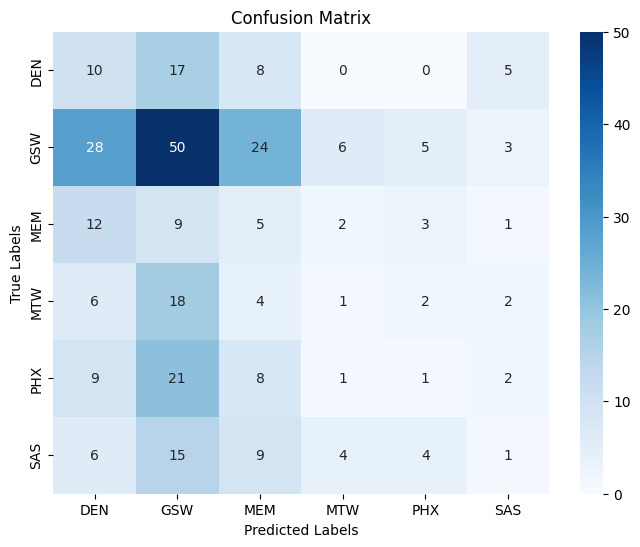

Confusion matrix for MLP


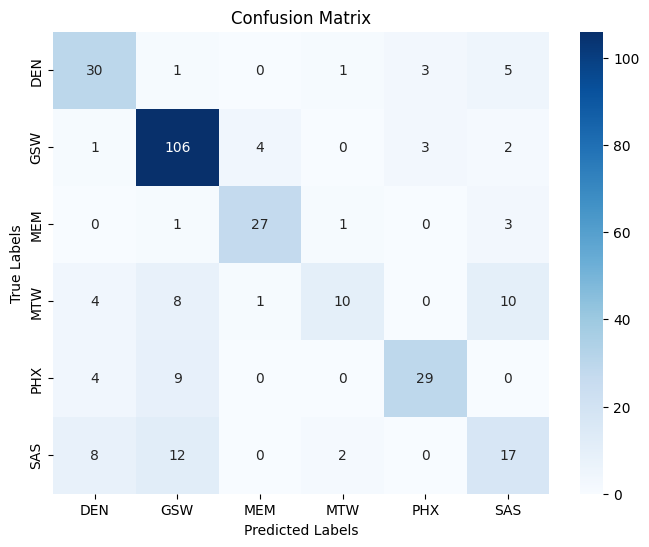

Confusion matrix for CNN


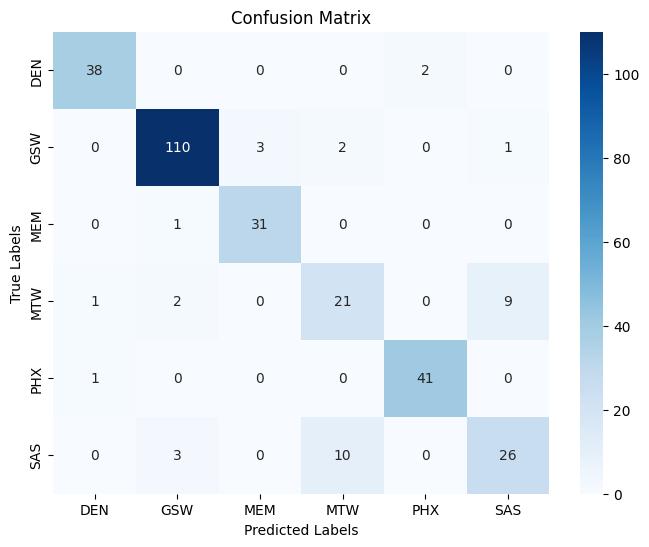

In [12]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

labels = sorted(list(set(train_labels)))

def plot_confusion_matrix(truth, predictions, labels):
    cm = confusion_matrix(truth, predictions, labels=labels)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, cmap='Blues', fmt='g',)
    plt.xlabel("Predicted Labels")
    plt.ylabel("True Labels")
    plt.title("Confusion Matrix")
    plt.xticks(ticks=np.arange(len(labels))+0.5, labels=labels)
    plt.yticks(ticks=np.arange(len(labels))+0.5, labels=labels)

    plt.show()

mlp_team_predictions = [labels[pred] for pred in mlp_predictions]
cnn_team_predictions = [labels[pred] for pred in cnn_predictions]
print('Confusion matrix for KNN')
plot_confusion_matrix(val_labels, team_predictions, labels)
print('Confusion matrix for MLP')
plot_confusion_matrix(val_labels, mlp_team_predictions, labels)
print('Confusion matrix for CNN')
plot_confusion_matrix(val_labels, cnn_team_predictions, labels)